## Определение перспективного тарифа телекомпании

### Описание проекта

У компании есть два тарифных планах "Смарт" и "Ультра", необходимо определить какой тариф приносит больше денег по выборке 500 клиентов.
  
| |«Смарт»|«Ультра»|
|--|--|--|
|Ежемесячная оплата|550|1950|
|Включено:|||
|Минут разговора|500|3000|
|Сообщений|50|1000|
|Гб трафика|15|30|
|Стоимость свыше:|||
|Минут разговора|3|1|
|Сообщений|3|1|
|Гб трафика|200|150|

Проверить 2 гипотезы:  
- Средняя выручка тарифов «Ультра» и «Смарт» различаются 
- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### Знакомство с данными и придение к нужным типам данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
try:
    df_users = pd.read_csv('users.csv', parse_dates=['churn_date', 'reg_date'])
    df_calls = pd.read_csv('calls.csv', parse_dates=['call_date'])
    df_messages = pd.read_csv('messages.csv', parse_dates=['message_date'])
    df_internet = pd.read_csv('internet.csv', parse_dates=['session_date'])
    df_tariffs = pd.read_csv('tariffs.csv')
except:
    df_users = pd.read_csv('/datasets/users.csv', parse_dates=['churn_date', 'reg_date'])
    df_calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
    df_messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
    df_internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'])
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')

In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [4]:
df_users[df_users.duplicated(subset=['last_name', 'first_name'])]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


In [5]:
df_users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

`df_users` - дубликатов нет, пропущенные значения только в дате прекращения пользования тарифом(но согласно документации, данный тариф действующий). Все данные в правильных форматах.

In [6]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [7]:
df_calls[df_calls.duplicated(subset='id')]

,id,call_date,duration,user_id


`df_calls` - необходимо поправить duration(длительность звонка в минутах), т.к. в описании тарифа должно быть округление до целого. соответственно привести к int. еще конечно в идеале id хранить в int, но не уверен что стоит сейчас это делать.

In [8]:
df_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [9]:
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
df_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


In [10]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.4+ MB


In [11]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


`df_messages` - Проблем не обнаружено, вроде все ок и все в правильном типе. Разве что можно поменять id на int

In [12]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [13]:
df_internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


`df_internet` : Затисалась странная колонка, которую стоит удалить. мб надо будет перевести в гб, после того сделается сводная таблица

In [14]:
df_internet.drop(columns='Unnamed: 0', inplace=True)

In [15]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [16]:
df_tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


`df_tariffs` - все ок.

**Общий вывод**:  
В целом данные хорошие, пропусков нет, дубликатов нет, возможно появяться скрытые проблемы после того как начну группировать/ проводить аналитику

### Добавление колонок и создание сводных таблиц

In [17]:
# Проверка что все действия за 2018год и не вписалось ничего лишнего
df_calls['call_date'].describe(datetime_is_numeric=True)
df_internet['session_date'].describe(datetime_is_numeric=True)
df_messages['message_date'].describe(datetime_is_numeric=True)

count                           123036
mean     2018-09-04 15:28:42.227640576
min                2018-01-02 00:00:00
25%                2018-07-09 00:00:00
50%                2018-09-20 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: message_date, dtype: object

In [18]:
df_calls['call_month'] = df_calls['call_date'].dt.month
df_internet['internet_month'] = df_internet['session_date'].dt.month
df_messages['message_month'] = df_messages['message_date'].dt.month

In [19]:
df_internet.columns

Index(['id', 'mb_used', 'session_date', 'user_id', 'internet_month'], dtype='object')

In [20]:
df_pivot_calls = df_calls.pivot_table(
    values=['duration'], index=['user_id', 'call_month'], aggfunc=['sum']).reset_index()
df_pivot_calls.columns = ['user_id', 'month', 'sum_duration']

In [21]:
df_pivot_internet = df_internet.pivot_table(
    values=['mb_used'], index=['user_id','internet_month'], aggfunc=['sum']).reset_index()
df_pivot_internet.columns = ['user_id','month', 'mb_used']

Сразу переведем мегабайты в гигабайты, которые требуются для расчета стоитмости

In [22]:
df_pivot_internet['gb_used'] = np.ceil(df_pivot_internet['mb_used'] / 1024).astype(int)
df_pivot_internet.drop(columns=['mb_used'], inplace=True)

In [23]:
df_messages.columns

Index(['id', 'message_date', 'user_id', 'message_month'], dtype='object')

In [24]:
df_pivot_messages = df_messages.pivot_table(
    values=['id'], index=['user_id', 'message_month'], aggfunc=['count']
).reset_index()
df_pivot_messages.columns = ['user_id', 'month', 'count_message']

In [25]:
df_users['reg_date'].describe(datetime_is_numeric=True)

count                              500
mean     2018-06-30 18:57:35.999999744
min                2018-01-01 00:00:00
25%                2018-04-07 12:00:00
50%                2018-07-02 12:00:00
75%                2018-09-29 00:00:00
max                2018-12-31 00:00:00
Name: reg_date, dtype: object

Создание основной сводной таблицы

In [26]:
df_users['reg_month'] = df_users['reg_date'].dt.month
df_users['unreg_month'] = df_users['churn_date'].dt.month

In [27]:
df_users.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff', 'reg_month', 'unreg_month'],
      dtype='object')

In [28]:
df_main = pd.DataFrame(columns=['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 
                                'reg_date', 'tariff', 'reg_month', 'unreg_month', 'month'])


In [29]:
def app_users(row):
    global df_main
    if row['unreg_month'] is None:
        max_month = row['unreg_month']
    else:
        max_month = 13
    for i in range(row['reg_month'] + 1, int(max_month)):
        row['month'] = i
        df_main = df_main.append(row)
    return row

In [30]:
df_users.apply(app_users, axis=1).head(1)

,age,churn_date,city,first_name,last_name,month,reg_date,reg_month,tariff,unreg_month,user_id
0,52,NaT,Краснодар,Рафаил,Верещагин,12.0,2018-05-25,5,ultra,NaN,1000


In [31]:
df_main = df_main.merge(df_pivot_internet, how='left', on=['user_id', 'month'])
df_main = df_main.merge(df_pivot_calls, how='left', on=['user_id', 'month'])
df_main = df_main.merge(df_pivot_messages, how='left', on=['user_id', 'month'])

Получили сводную таблицу, только с полными месяцами использования. Есть некоторые месяцы с пропусками, скорее всего связано с тем, что человек не пользовался услугами связи в эти месяцы. Заполним нулями, чтоб пропуски отображались в статистике

In [32]:
columns_for_change_none = ['sum_duration', 'gb_used', 'count_message']
for column in columns_for_change_none:
    df_main[column].fillna(value=0, inplace=True)

In [33]:
df_main.rename(columns={'tariff' : 'tariff_name'}, inplace=True)
df_main = df_main.merge(df_tariffs, how='outer', on='tariff_name')

<AxesSubplot:>

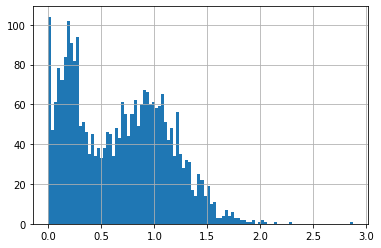

In [34]:
# Какой % использован из выделенного тарифа
df_main['per_minutes'] = df_main['sum_duration'] / df_main['minutes_included']
df_main['per_minutes'].hist(bins=100)

Наткнулся на проблему: что есть включенные мегабайты, а цена за гигабайты... поэтому переводим в гигабайты как делали ранее

In [35]:
df_main['gb_included'] = (df_main['mb_per_month_included']/1024).astype(int)
df_main.drop(columns='mb_per_month_included', inplace=True)

In [36]:
def check_money(include, spent, price):
    def check_money_inside(row):
        nonlocal include, spent, price
        if row[spent] <= row[include]:
            return 0 
        elif row[spent] > row[include]:
            return (row[spent] - row[include])*row[price] 
    return check_money_inside
    
minutes = check_money('minutes_included', 'sum_duration', 'rub_per_minute')
internet = check_money('gb_included', 'gb_used', 'rub_per_gb')
messages = check_money('messages_included', 'count_message', 'rub_per_message')

In [37]:
def check_money(include, spent, price):
    '''Функция для подсчета затраченного сверх тарифа(минут/гб/смс)'''
    def check_money_inside(row):
        nonlocal include, spent, price
        return 0 if row[spent] <= row[include] else (row[spent] - row[include])*row[price]
    return check_money_inside
    
minutes = check_money('minutes_included', 'sum_duration', 'rub_per_minute')
internet = check_money('gb_included', 'gb_used', 'rub_per_gb')
messages = check_money('messages_included', 'count_message', 'rub_per_message')

In [38]:
df_main['total_rub_duration'] = df_main.apply(minutes, axis=1)
df_main['total_rub_internet'] = df_main.apply(internet, axis=1)
df_main['total_rub_messages'] = df_main.apply(messages, axis=1)
df_main['total_rub_service'] = df_main['total_rub_duration'] + \
    df_main['total_rub_internet'] + df_main['total_rub_messages'] 
df_main['total_rub'] = df_main['total_rub_service'] + \
    df_main['rub_monthly_fee']

Данные подготовил, далее идет аналитика, гипотезы и т.п., предварительно удаляю все левые переменные, чтоб глаза не мазолили

In [39]:
del df_calls, df_internet, df_users, df_tariffs, df_messages
del df_pivot_calls, df_pivot_internet, df_pivot_messages, 
del column, columns_for_change_none

### Ответы на вопросы и анализ

In [ ]:
df_median = df_pivot_all.pivot_table(values='total_rub', index=[
    'month', 'tariff_name'], aggfunc=('median', 'mean', 'max', 'min')).reset_index()
df_median.head(2)

In [ ]:

df_median.columns = ['month', 'tariff_name', 'max', 'mean', 'median', 'min']
df_median.query('tariff_name == "smart"').plot(kind='line', x='month', y='median', subplots=True)
df_median.query('tariff_name == "ultra"').plot(kind='line', x='month', y='median', subplots=True)
plt.show()

In [ ]:
df_median.sort_values(by=['tariff_name', 'month'])

In [ ]:
df_pivot_all.columns